  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.000e-01  1.000e+00  1.500e+00  2.000e+00
             2.500e+00  3.000e+00  3.500e+00  4.000e+00]
        y: [[ 2.507e-46 -1.036e-13 ...  3.814e-11 -4.597e-11]
            [ 1.178e-43  6.536e-14 ... -4.786e-11  2.096e-11]
            ...
            [ 6.190e-41  1.830e-13 ... -1.639e-10  1.793e-10]
            [ 1.602e-43 -1.302e-13 ...  7.350e-11 -1.677e-10]]
      sol: None
 t_events: None
 y_events: None
     nfev: 62
     njev: 0
      nlu: 0


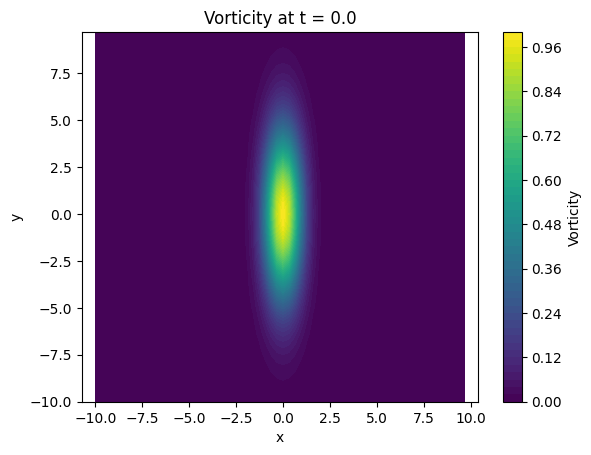

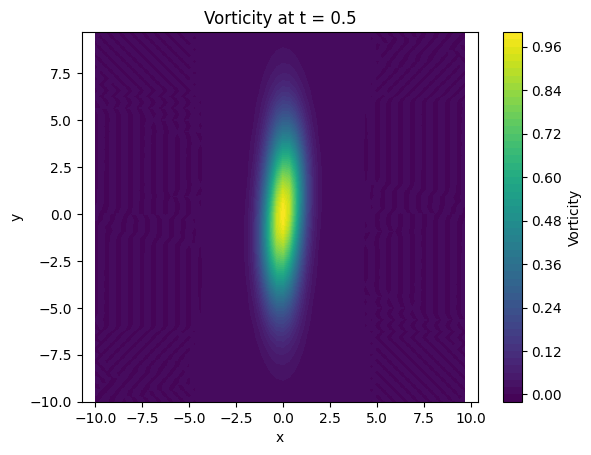

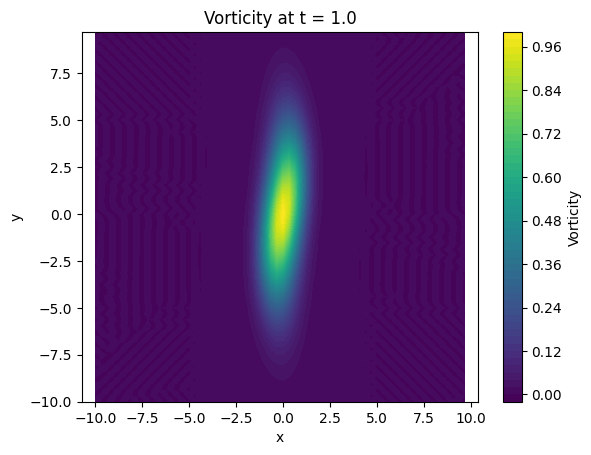

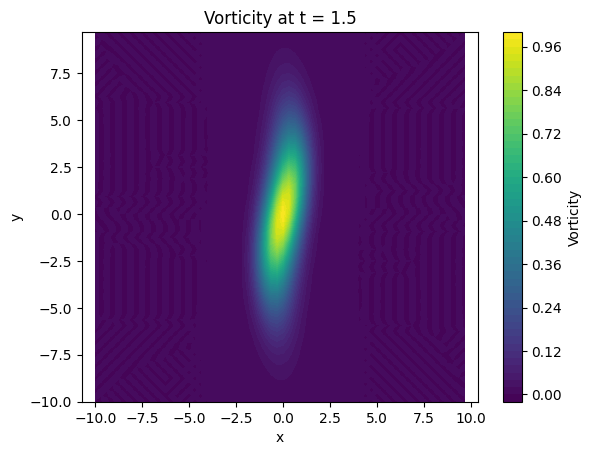

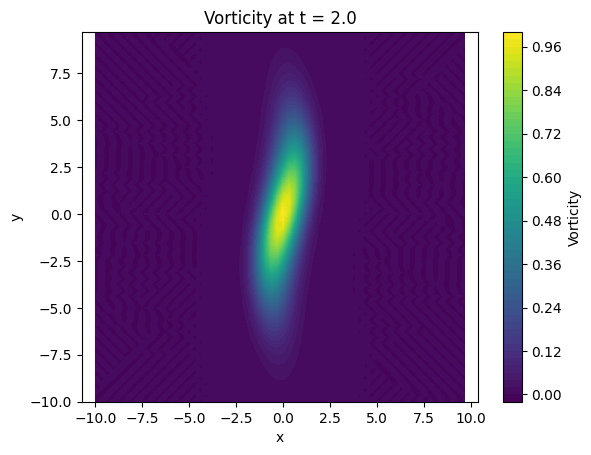

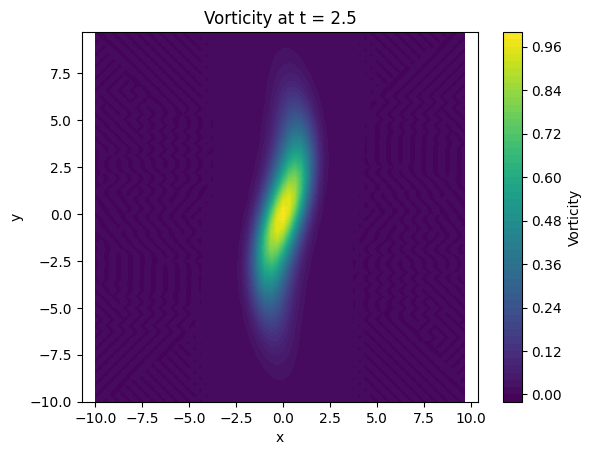

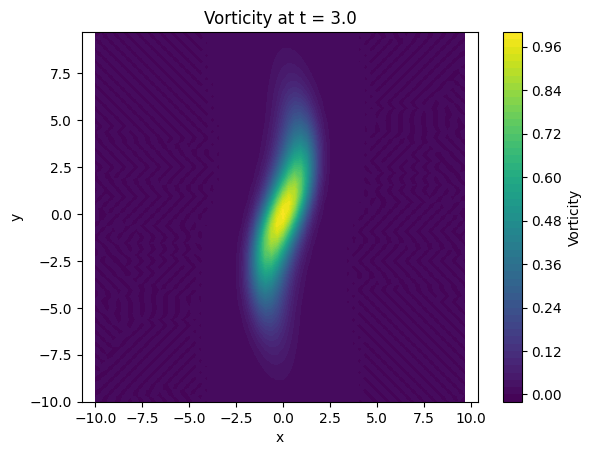

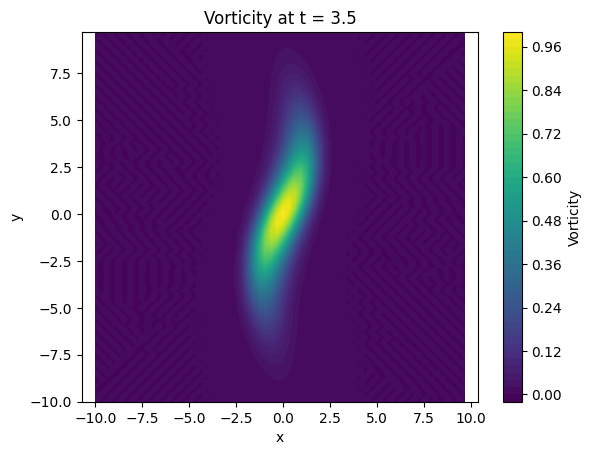

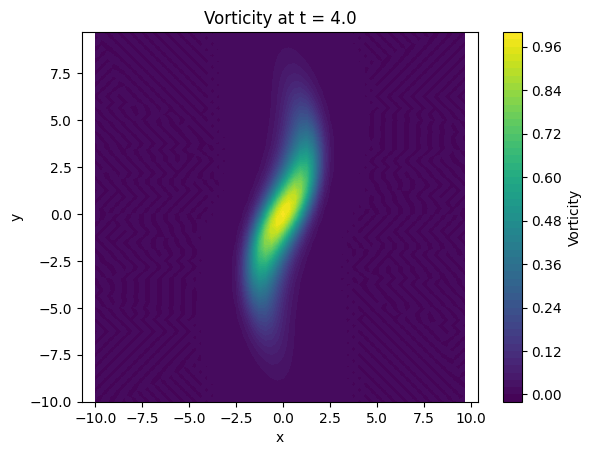

In [6]:
import numpy as np
from scipy.fft import fft2, ifft2, fftfreq
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.linalg import lu, solve_triangular
from scipy.sparse import diags
from scipy.sparse.linalg import bicgstab, gmres
import time
from scipy.sparse import spdiags

L = 10
m = 8
n = m * m
delta = (2 * L) / m

e0 = np.zeros((n, 1))
e1 = np.ones((n, 1))
e2 = np.copy(e1)
e4 = np.copy(e0)

for j in range (1, m + 1):
    e2[m * j - 1] = 0
    e4[m * j - 1] = 1

e3 = np.zeros_like(e2)
e5 = np.zeros_like(e4)

for i in range (1, n):
    e3[i] = e2[i - 1]
    e5[i] = e4[i - 1]
e3[0] = e2[-1]
e5[0] = e4[-1]

diagonals_A = [e1.flatten(), e1.flatten(), e5.flatten(),
               e2.flatten(), -4 * e1.flatten(), e3.flatten(),
               e4.flatten(), e1.flatten(), e1.flatten()]
offsets_A = [-(n - m), -m, -m + 1, -1, 0, 1, m - 1, m, (n - m)]

A = spdiags(diagonals_A, offsets_A, n, n) / (delta ** 2)

diagonals_B = [e1.flatten(), -e1.flatten() , e1.flatten(), -e1.flatten()]
offsets_B = [-(n-m), -m, m, (n-m)]
B = spdiags(diagonals_B, offsets_B, n, n) / (2 * delta)

for i in range (1, n):
    e1[i] = e4[i - 1]

diagonals_C = [e1.flatten (), -e2.flatten (), e3.flatten(), -e4.flatten()]
offsets_C = [-m + 1, -1, 1,  m - 1 ]
C = spdiags(diagonals_C, offsets_C, n, n) / (2 * delta)

A = A.toarray()
B = B.toarray()
C = C.toarray()

# Parameters
L = 20  # Domain size
n = 64  # Grid points
dx = L / n
x = np.linspace(-L / 2, L / 2, n, endpoint=False)
y = np.linspace(-L / 2, L / 2, n, endpoint=False)
X, Y = np.meshgrid(x, y)
nu = 0.001  # Diffusion coefficient

# Initial condition
omega_0 = np.exp(-X**2 - Y**2 / 20)

# Wave numbers
kx = fftfreq(n, d=dx) * 2 * np.pi
ky = fftfreq(n, d=dx) * 2 * np.pi
kx[0], ky[0] = 1e-6, 1e-6  # Avoid division by zero
K2 = kx[:, None]**2 + ky[None, :]**2

# Define the vorticity evolution function
def vorticity_rhs(t, omega):
    omega = omega.reshape((n, n))
    omega_hat = fft2(omega)

    # Compute psi using FFT
    psi_hat = omega_hat / (-K2)
    psi_hat[0, 0] = 0  # Mean component = 0
    psi = np.real(ifft2(psi_hat))

    # Compute the Jacobian [ψ, ω]
    psi_x = np.real(ifft2(1j * kx[:, None] * psi_hat))
    psi_y = np.real(ifft2(1j * ky[None, :] * psi_hat))
    omega_x = np.real(ifft2(1j * kx[:, None] * omega_hat))
    omega_y = np.real(ifft2(1j * ky[None, :] * omega_hat))
    jacobian = psi_x * omega_y - psi_y * omega_x

    # Diffusion term
    laplacian_omega = np.real(ifft2(-K2 * omega_hat))

    # Time derivative
    d_omega_dt = -jacobian + nu * laplacian_omega
    return d_omega_dt.flatten()


omega_0 = np.exp(-X**2 - Y**2 / 20).flatten()

# Solve using solve_ivp
t_span = (0, 4)
t_eval = np.arange(0, 4.5, 0.5)
sol = solve_ivp(vorticity_rhs, t_span, omega_0.flatten(), t_eval=t_eval, method='RK45')

# # Direct Solver (A\b)
# rhs = omega_0.copy()
# start_time = time.time()
# psi_direct = np.linalg.solve(A, rhs)
# end_time = time.time()
# print(f"Direct Solver Time: {end_time - start_time:.2f} seconds")

# # LU decomposition
# start_time = time.time()
# P, L, U = lu(A)
# Pb = P @ rhs
# y = solve_triangular(L, Pb, lower=True)
# psi_lu = solve_triangular(U, y)
# end_time = time.time()
# print(f"LU Solver Time: {end_time - start_time:.2f} seconds")

A1 = sol
#A[0][0] = 2


print(A1)


# Reshape and visualize
for i, t in enumerate(sol.t):
    omega_t = sol.y[:, i].reshape((n, n))
    plt.figure()
    plt.contourf(X, Y, omega_t, levels=50, cmap='viridis')
    plt.colorbar(label='Vorticity')
    plt.title(f'Vorticity at t = {t:.1f}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.show()


In [ ]:
import numpy as np
from scipy.linalg import lu, solve_triangular
from scipy.sparse import diags
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time

# Parameters
L = 20  # Domain size
n = 64  # Grid points
dx = L / n
x = np.linspace(-L / 2, L / 2, n, endpoint=False)
y = np.linspace(-L / 2, L / 2, n, endpoint=False)
X, Y = np.meshgrid(x, y)
nu = 0.001  # Diffusion coefficient

# Initial condition
omega_0 = np.exp(-X**2 - Y**2 / 20)

# Construct finite difference Laplacian matrix for ∇²ψ = ω
I = np.eye(n)
e = np.ones(n)
data = [-2*e, e, e]
diagonals = [0, 1, -1]
D1 = diags(data, diagonals, shape=(n, n)).toarray() / dx**2  # 1D Laplacian
D1[0, -1] = D1[-1, 0] = 1 / dx**2  # Periodic BCs

Laplacian = np.kron(I, D1) + np.kron(D1, I)  # 2D Laplacian
A = -Laplacian.copy()

# e0 = np.zeros((n, 1))
# e1 = np.ones((n, 1))
# e2 = np.copy(e1)
# e4 = np.copy(e0)

# for j in range (1, m + 1):
#     e2[m * j - 1] = 0
#     e4[m * j - 1] = 1

# e3 = np.zeros_like(e2)
# e5 = np.zeros_like(e4)

# for i in range (1, n):
#     e3[i] = e2[i - 1]
#     e5[i] = e4[i - 1]
# e3[0] = e2[-1]
# e5[0] = e4[-1]

# diagonals_A = [e1.flatten(), e1.flatten(), e5.flatten(),
#                e2.flatten(), -4 * e1.flatten(), e3.flatten(),
#                e4.flatten(), e1.flatten(), e1.flatten()]
# offsets_A = [-(n - m), -m, -m + 1, -1, 0, 1, m - 1, m, (n - m)]

# A = spdiags(diagonals_A, offsets_A, n, n) / (dx ** 2)
# A.toarray()

# Wave numbers
kx = fftfreq(n, d=dx) * 2 * np.pi
ky = fftfreq(n, d=dx) * 2 * np.pi
kx[0], ky[0] = 1e-6, 1e-6  # Avoid division by zero
K2 = kx[:, None]**2 + ky[None, :]**2

# Define the vorticity evolution function
def vorticity_rhs(t, omega):
    omega = omega.reshape((n, n))
    omega_hat = fft2(omega)

    # Compute psi using FFT
    psi_hat = omega_hat / (-K2)
    psi_hat[0, 0] = 0  # Mean component = 0
    psi = np.real(ifft2(psi_hat))

    # Compute the Jacobian [ψ, ω]
    psi_x = np.real(ifft2(1j * kx[:, None] * psi_hat))
    psi_y = np.real(ifft2(1j * ky[None, :] * psi_hat))
    omega_x = np.real(ifft2(1j * kx[:, None] * omega_hat))
    omega_y = np.real(ifft2(1j * ky[None, :] * omega_hat))
    jacobian = psi_x * omega_y - psi_y * omega_x

    # Diffusion term
    laplacian_omega = np.real(ifft2(-K2 * omega_hat))

    # Time derivative
    d_omega_dt = -jacobian + nu * laplacian_omega
    return d_omega_dt.flatten()


omega_0 = np.exp(-X**2 - Y**2 / 20).flatten()

# Solve using solve_ivp
t_span = (0, 4)
t_eval = np.arange(0, 4.5, 0.5)

start_time = time.time()
sol = solve_ivp(vorticity_rhs, t_span, omega_0.flatten(), t_eval=t_eval, method='RK45')
end_time = time.time()
print(f"fft elapsed time: {end_time - start_time:.2f} seconds")

A[0, 0] = 2  # Modify A(0, 0) as per the instructions

# Define the vorticity evolution function
def solve_psi_direct(omega):
    b = omega.flatten()
    psi = np.linalg.solve(A, b)
    return psi.reshape((n, n))

def solve_psi_lu(omega):
    P, L, U = lu(A)
    b = omega.flatten()
    Pb = np.dot(P, b)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    return psi.reshape((n, n))

def vorticity_rhs(t, omega, method='direct'):
    omega = omega.reshape((n, n))

    # Solve ∇²ψ = ω
    if method == 'direct':
        psi = solve_psi_direct(omega)
    elif method == 'lu':
        psi = solve_psi_lu(omega)

    # Compute the Jacobian [ψ, ω]
    psi_x = np.gradient(psi, axis=1) / dx
    psi_y = np.gradient(psi, axis=0) / dx
    omega_x = np.gradient(omega, axis=1) / dx
    omega_y = np.gradient(omega, axis=0) / dx
    jacobian = psi_x * omega_y - psi_y * omega_x

    # Diffusion term
    laplacian_omega = np.gradient(np.gradient(omega, axis=0), axis=0) / dx**2 + \
                      np.gradient(np.gradient(omega, axis=1), axis=1) / dx**2

    # Time derivative
    d_omega_dt = -jacobian + nu * laplacian_omega
    return d_omega_dt.flatten()

# Solve using direct method
start_time = time.time()
sol_direct = solve_ivp(vorticity_rhs, (0, 4), omega_0.flatten(), args=('direct',), t_eval=np.arange(0, 4.5, 0.5), method='RK45')
end_time = time.time()
print(f"Direct method elapsed time: {end_time - start_time:.2f} seconds")

# Solve using LU method
start_time = time.time()
sol_lu = solve_ivp(vorticity_rhs, (0, 4), omega_0.flatten(), args=('lu',), t_eval=np.arange(0, 4.5, 0.5), method='RK45')
end_time = time.time()
print(f"LU method elapsed time: {end_time - start_time:.2f} seconds")

A1 = sol
A2 = sol_direct
A3 = sol_lu

print(A1)
print(A2)
print(A3)

# Visualization
for i, t in enumerate(sol_direct.t):
    omega_t = sol.y[:, i].reshape((n, n))
    omega_t_direct = sol_direct.y[:, i].reshape((n, n))
    omega_t_lu = sol_lu.y[:, i].reshape((n, n))
    
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.contourf(X, Y, omega_t, levels=50, cmap='viridis')
    plt.colorbar(label='Vorticity')
    plt.title(f'fft, t = {t:.1f}')
    plt.xlabel('x')
    plt.ylabel('y')

    plt.subplot(1, 3, 2)
    plt.contourf(X, Y, omega_t_direct, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title(f'Direct Method, t={t:.1f}')
    
    plt.subplot(1, 3, 3)
    plt.contourf(X, Y, omega_t_lu, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title(f'LU Method, t={t:.1f}')
    
    plt.show()


fft elapsed time: 0.06 seconds


TypeError: 'dia_matrix' object does not support item assignment